In [1]:
import os
import torch
import pickle

In [2]:
import wandb
import mplhep as hep
hep.style.use("CMS")
import matplotlib
matplotlib.rc('font', size=13)


In [3]:
import os
os.environ.get("LD_LIBRARY_PATH")

'/eos/home-g/gkrzmanc/miniforge3/lib:/home/gkrzmanc/env/lib:'

In [4]:
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import torch
print("CUDA available:", torch.cuda.is_available())  # in case needed


def get_dataset():
    path = "/afs/cern.ch/work/g/gkrzmanc/mlpf_results/clustering_gt_with_pid_and_mean_features/cluster_features"
    r = {}
    n = 0
    #nmax = 257
    for file in os.listdir(path):
        #n += 1
        #if n > nmax:
        #    break
        f = pickle.load(open(os.path.join(path, file), "rb"))
        for key in f:
            if key not in r:
                r[key] = f[key]
            else:
                r[key] = torch.concatenate((r[key], f[key]), axis=0)
    x_names = ["ecal_E", "hcal_E", "num_hits", "track_p", "ecal_dispersion", "hcal_dispersion", "sum_e", "num_tracks"]
    print("x shape:", r["x"].shape)
    return r["x"], x_names, r["true_e_corr"], r["e_true"], r["e_reco"], r["y_particles"][:, 6]

def get_split(ds):
    from sklearn.model_selection import train_test_split
    x, _, y, etrue, _, pids = ds
    xtrain, xtest, ytrain, ytest, energiestrain, energiestest, pid_train, pid_test = train_test_split(
        x, y, etrue, pids, test_size=0.2, random_state=42
    )
    return xtrain, xtest, ytrain, ytest, energiestrain, energiestest, pids

def get_gb():
    from sklearn.ensemble import GradientBoostingRegressor
    model = GradientBoostingRegressor(verbose=1)
    return model


def main(ds, train_only_on_tracks=False, train_only_on_neutral=False, train_energy_regression=False):
    split = list(get_split(ds))
    gpus = [0]
    wandb.init(project="mlpf_debug_energy_corr", entity="fcc_ml")
    #wandb.run.name = "Debug E correction"
    model = "gradboost"
    #wandb.run.model = model
    if model == "gradboost":
        model = get_gb()
        if train_only_on_tracks:
            mask = (split[0][:, 3] > 0) & (split[0][:, 7] > 0)
            split[0] = split[0][mask]
            split[2] = split[2][mask]
            split[4] = split[4][mask]
        elif train_only_on_neutral:
            mask = (split[0][:, 3] == 0) & (split[0][:, 7] == 0)
            split[0] = split[0][mask]
            split[2] = split[2][mask]
            split[4] = split[4][mask]
        if not train_energy_regression:
            result = model.fit(split[0], split[2])
            print("Fitted model:", result)
            # validation
            ypred = model.predict(split[1])
            ytrue = split[3]
            energies = split[5]
            return ytrue, ypred, energies, split[1], model, split
        else:
            result = model.fit(split[0], split[4])
            print("Fitted model:", result)
            # validation
            epred = model.predict(split[1])
            ytrue = split[3]
            ysum = split[1][:, 6]
            ypred = epred / ysum - 1
            energies = split[5]
            return ytrue, epred, energies, split[1], model, split
        # log scatterplots of validation results per energy
    else:
        raise NotImplementedError

def main_pandora():
    # just take the track p and energy of the hits for regression - so, "quasi-pandora"
    ds = get_dataset()
    print("Loaded dataset")
    split = get_split(ds)
    gpus = [0]
    wandb.init(project="mlpf_debug_energy_corr", entity="fcc_ml")
    #wandb.run.name = "Debug E correction"
    model = "gradboost"
    #wandb.run.model = model
    if model == "gradboost":
        model = get_gb()
        result = model.fit(split[0][:, [3, 6]], split[2])
        print("Fitted model:", result)
        # validation
        ypred = model.predict(split[1][:, [3, 6]])
        ytrue = split[3]
        energies = split[5]
        return ytrue, ypred, energies, split[1][:, [3, 6]], model, split
        # log scatterplots of validation results per energy
    else:
        raise NotImplementedError


CUDA available: True


In [5]:
ds = get_dataset()
print("Loaded dataset")

x shape: torch.Size([119348, 8])
Loaded dataset


In [6]:
neutral_yt, neutral_yp, neutral_en, _, neutral_model, neutral_split = main(ds=ds, train_only_on_neutral=True)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
OpenBLAS blas_thread_init: pthread_create failed for thread 52 of 64: Resource temporarily unavailable
OpenBLAS blas_thread_init: RLIMIT_NPROC 4096 current, 1888409 max
OpenBLAS blas_thread_init: pthread_create failed for thread 53 of 64: Resource temporarily unavailable
OpenBLAS blas_thread_init: RLIMIT_NPROC 4096 current, 1888409 max
OpenBLAS blas_thread_init: pthread_create failed for thread 54 of 64: Resource temporarily unavailable
OpenBLAS blas_thread_init: RLIMIT_NPROC 4096 current, 1888409 max
OpenBLAS blas_thread_init: pthread_create failed for thread 55 of 64: Resource temporarily unavailable
OpenBLAS blas_thread_init: RLIMIT_NPROC 4096 current, 1888409 max
OpenBLAS blas_thread_init: pthread_create failed for thread 56 of 64: Resource temporarily unavailable
OpenBLAS blas_thread_init: RLIMIT_NPROC 4096 current, 1888409 max
OpenBLAS blas_

ServiceStartProcessError: The wandb service process exited with -2. Ensure that `sys.executable` is a valid python interpreter. You can override it with the `_executable` setting or with the `WANDB__EXECUTABLE` environment variable.

In [10]:
#yt, yp, en, _, model, split = main(ds=ds, train_only_on_tracks=True)

      Iter       Train Loss   Remaining Time 
         1           8.3034           18.09s
         2           6.8660           14.39s
         3           5.6901           12.76s
         4           4.7310           12.28s
         5           3.9499           11.61s
         6           3.3139           11.24s
         7           2.7884           11.24s
         8           2.3613           11.81s
         9           2.0103           12.09s
        10           1.7210           11.72s
        20           0.5492           10.05s
        30           0.3157            8.77s
        40           0.2284            7.34s
        50           0.1831            5.87s
        60           0.1534            4.57s
        70           0.1285            3.35s
        80           0.1177            2.20s
        90           0.1078            1.09s
       100           0.1007            0.00s
Fitted model: GradientBoostingRegressor(verbose=1)


In [7]:
yt_regression, yp_regression, en_regression, _, model_regression, split_regression = main(ds=ds, train_only_on_tracks=True, train_energy_regression=True)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: gregorkrz (fcc_ml). Use `wandb login --relogin` to force relogin


      Iter       Train Loss   Remaining Time 
         1         127.6830           10.15s
         2         104.3204            9.85s
         3          85.2594            9.64s
         4          69.7293            9.47s
         5          57.1096            9.32s
         6          46.9030            9.18s
         7          38.5274            9.09s
         8          31.6779            8.98s
         9          26.1572            8.86s
        10          21.6279            8.75s
        20           4.1696            7.72s
        30           1.6260            6.75s
        40           1.0732            6.14s
        50           0.8774            5.15s
        60           0.7719            4.35s
        70           0.7082            3.35s
        80           0.6606            2.23s
        90           0.6210            1.10s
       100           0.5858            0.00s
Fitted model: GradientBoostingRegressor(verbose=1)


In [ ]:
def plot(ytrue, ypred, energies):
        bins = [0, 1, 2, 5, 10, 15, 30, 50]
        fig, ax = plt.subplots(4, 1, figsize=(8, 15))
        for i in range(len(bins) - 1):
            mask = (energies > bins[i]) & (energies < bins[i + 1])
            ax[0].scatter(ytrue[mask], ypred[mask], label=f"{bins[i]}-{bins[i+1]} GeV", alpha=0.2)
            # plot identity line
            ax[0].plot([0, 100], [0, 100], color="gray", linestyle="--")
            ax[1].plot([0, 100], [0, 100], color="gray", linestyle="--")
            ax[1].scatter(1+ytrue[mask], 1+ypred[mask], label=f"{bins[i]}-{bins[i + 1]} GeV", alpha=0.2)
        ax[0].set_xlabel("True E corr. fact.")
        ax[0].set_ylabel("Predicted E corr. fact.")
        ax[1].set_xlabel("1+True E corr. fact.")
        ax[1].set_ylabel("1+Predicted E corr. fact.")
        # ax1 is in logscale
        ax[1].set_yscale("log")
        ax[1].set_xscale("log")
        ax[0].legend()
        ax[1].legend()
        # ax 2 and 3 just plot a histogram of the true and predicted values
        ax[2].hist(ytrue, bins=500, histtype="step", label="True")
        ax[2].set_xlabel("True E corr. fact. - min: " + str(round(ytrue.min().item(), 2)) + " max:" + str(round(ytrue.max().item(), 2)))
        ax[2].set_ylabel("Count")
        ax[2].legend()
        ax[2].set_yscale("log")
        ##########################
        ax[2].hist(ytrue, bins=500, histtype="step", label="True")
        ax[2].hist(ypred, bins=500, histtype="step", label="Predicted")
        ax[2].set_xlabel("True E corr. fact. - min: " + str(ytrue.min().item()) + " max:" + str(ytrue.max().item()))
        ax[2].set_ylabel("Count")
        ax[2].legend()
        ax[2].set_yscale("log")
        wandb.log({"validation": wandb.Image(fig)})

plot(yt, yp, en)

In [ ]:
# ... Plotting with the energy of the sum of the hits...
plot(yt, yp, split[1][:, 6])

In [ ]:
def plot1(ytrue, ypred, energies):
        bins = [0, 1, 2, 5, 10, 15, 30, 50]
        fig, ax = plt.subplots(4, 1, figsize=(8, 15))
        for i in range(len(bins) - 1):
            if i not in [0, 1, 2]:
                continue
            mask = (energies > bins[i]) & (energies < bins[i + 1])
            ax[0].scatter(ytrue[mask], ypred[mask], label=f"{bins[i]}-{bins[i+1]} GeV", alpha=0.2)
            # plot identity line
            ax[0].plot([0, 100], [0, 100], color="gray", linestyle="--")
            ax[1].plot([0, 100], [0, 100], color="gray", linestyle="--")
            ax[1].scatter(ytrue[mask], ypred[mask], label=f"{bins[i]}-{bins[i + 1]} GeV", alpha=0.2)
        ax[0].set_xlabel("True E corr. fact.")
        ax[0].set_ylabel("Predicted E corr. fact.")
        ax[1].set_xlabel("True E corr. fact.")
        ax[1].set_ylabel("Predicted E corr. fact.")
        # ax1 is in logscale
        ax[1].set_yscale("log")
        ax[1].set_xscale("log")
        ax[0].legend()
        ax[1].legend()
        # ax 2 and 3 just plot a histogram of the true and predicted values
        #ax[2].hist(ytrue, bins=500, histtype="step", label="True")
        ax[2].set_xlabel("True E corr. fact. - min: " + str(round(ytrue.min().item(), 2)) + " max:" + str(round(ytrue.max().item(), 2)))
        ax[2].set_ylabel("Count")
        ax[2].legend()
        ax[2].set_yscale("log")
        ##########################
        ax[2].hist(ytrue, bins=500, histtype="step", label="True")
        ax[2].hist(ypred, bins=500, histtype="step", label="Predicted")
        ax[2].set_xlabel("True E corr. fact. - min: " + str(ytrue.min().item()) + " max:" + str(ytrue.max().item()))
        ax[2].set_ylabel("Count")
        ax[2].legend()
        ax[2].set_yscale("log")
        wandb.log({"validation": wandb.Image(fig)})
plot1(yt, yp, en)

In [16]:
import shap
import numpy as np
te = shap.TreeExplainer(model)
shap_vals = te.shap_values(np.array(split[1]))

In [ ]:
x_names = ["ecal_E", "hcal_E", "num_hits", "track_p", "ecal_dispersion", "hcal_dispersion", "sum_e", "num_tracks"]
shap.summary_plot(shap_vals, split[1], feature_names=x_names, use_log_scale=True, show=False)
plt.savefig("/eos/user/g/gkrzmanc/2024/12_3_/shap_summary_tracks.pdf")

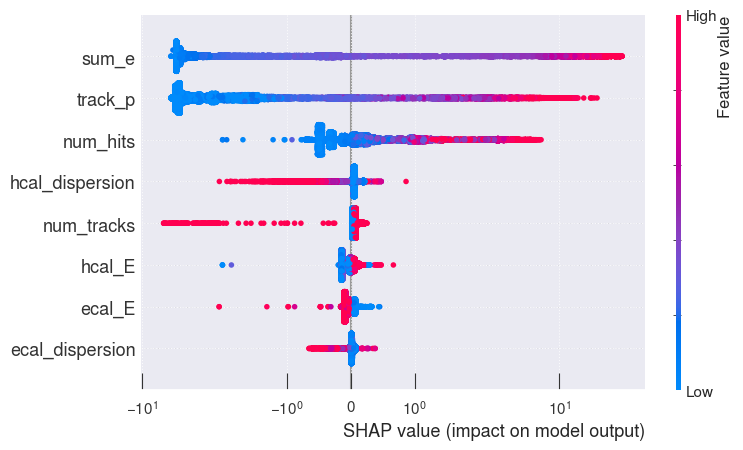

In [12]:
import shap
import numpy as np

te = shap.TreeExplainer(model_regression)
shap_vals_r = te.shap_values(np.array(split[1]))
x_names = ["ecal_E", "hcal_E", "num_hits", "track_p", "ecal_dispersion", "hcal_dispersion", "sum_e", "num_tracks"]
shap.summary_plot(shap_vals_r, split[1], feature_names=x_names, use_log_scale=True, show=False)
plt.savefig("/eos/user/g/gkrzmanc/2024/12_3_/shap_summary_tracks_Regression.pdf")

In [ ]:
# just plot sum_e vs. true_e_corr.factor
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.scatter(split[1][:, 6], 1+yt, label="True", alpha=0.2)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Sum E")
ax.set_ylabel("1 + True E corr. factor")
fig.show()

In [ ]:
# just plot sum_e vs. true_e_corr.factor
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.scatter(split[1][:, 3], 1+yt, alpha=0.2)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Sum E")
ax.set_ylabel("1 + True E corr. factor")
fig.show()

tensor(24214) 24214


NameError: name 'yt_pandora' is not defined

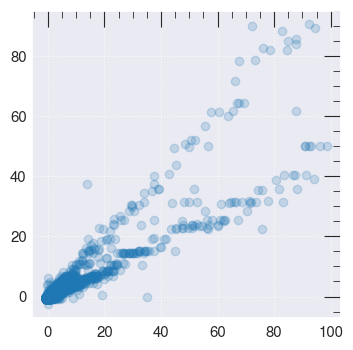

In [13]:
energies = split[1][:, 6]
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
#mask = (energies > 0) & (energies < 1)
mask = (split[1][:, 3] > 0) & (split[1][:, 7] > 0)  # TRACKS
mask = energies > 0
print(mask.sum(), len(mask))
ax.scatter(yt[mask], yp[mask], label=f"All features", alpha=0.2)
ax.scatter(yt_pandora[mask], yp_pandora[mask], label=f"E+p", alpha=0.2)
# correlation coeff.
from scipy.stats import pearsonr
r, p = pearsonr(yt[mask], yp[mask])
r_pandora, p_pandora = pearsonr(yt_pandora[mask], yp_pandora[mask])
print("Correlation coeff. all features:", r, p)
print("Correlation coeff. E+p:", r_pandora, p_pandora)
ax.plot([0, 100], [0, 100], color="gray", linestyle="--")
ax.set_xlabel("True E corr. fact.")
ax.set_ylabel("Predicted E corr. fact.")
ax.legend()
fig.show()

In [ ]:
# define bins of the predicted corr. factor
bins = [-1, -0.75, -0.5, -0.25, -0.1, 0.1, 0.25, 0.5, 0.75, 1, 3, 5, 7, 10, 15, 30, 50, 100]
bins = [-1, -0.5, -0.1, 0.1, 0.5, 1, 5, 10, 50, 100]
n_plots = len(bins) - 1
corr_coeffs_ep, corr_coefs = [], []
bin_avg = []
fig, ax = plt.subplots(1, n_plots, figsize=(4*n_plots, 4))
track_filter = ((split[1][:, 3] > 0) & (split[1][:, 7] > 0).clone().detach().cpu().numpy())
import numpy as np
for i in range(len(bins) - 1):
    mask = (yp > bins[i]) & (yp < bins[i + 1]) & (track_filter).detach().cpu().numpy()
    bin_avg.append(yp[mask].mean())
    ax[i].scatter(yt[mask], yp[mask], alpha=0.2, label="all feat.")
    ax[i].scatter(yt_pandora[mask], yp_pandora[mask], alpha=0.2, label="E+p")
    cc = round(pearsonr(yt[mask], yp[mask])[0], 2)
    cc_ep = round(pearsonr(yt_pandora[mask], yp_pandora[mask])[0], 2)
    corr_coeffs_ep.append(cc_ep)
    corr_coefs.append(cc)
    ax[i].set_title(f"{bins[i]}-{bins[i+1]} (cc = {cc} / {cc_ep})")
    #ax[i].plot([0, 100], [0, 100], color="gray", linestyle="--")
    ax[i].set_xlabel("True E corr. fact.")
    ax[i].set_ylabel("Predicted E corr. fact.")
    ax[i].legend()
fig.tight_layout()
#fig.savefig("/eos/user/g/gkrzmanc/2024/xgb_correction/energy_corr_vs_true_corr_regions.pdf")
fig.show()


In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.plot(bin_avg, corr_coefs, ".--", label="All features")
ax.plot(bin_avg, corr_coeffs_ep, ".--", label="E+p")
ax.set_xlabel("Average predicted E corr. factor")
ax.set_ylabel("Correlation coefficient")
ax.legend()
fig.show()

In [11]:
import numpy as np
def get_std68(theHist, bin_edges, percentage=0.683, epsilon=0.01):
    # theHist, bin_edges = np.histogram(data_for_hist, bins=bins, density=True)
    wmin = 0.2
    wmax = 1.0

    weight = 0.0
    points = []
    sums = []

    # fill list of bin centers and the integral up to those point
    for i in range(len(bin_edges) - 1):
        weight += theHist[i] * (bin_edges[i + 1] - bin_edges[i])
        points.append([(bin_edges[i + 1] + bin_edges[i]) / 2, weight])
        sums.append(weight)
    low = wmin
    high = wmax
    width = 100
    for i in range(len(points)):
        for j in range(i, len(points)):
            wy = points[j][1] - points[i][1]
            if abs(wy - percentage) < epsilon:
                wx = points[j][0] - points[i][0]
                if wx < width:
                    low = points[i][0]
                    high = points[j][0]
                    width = wx
                    # ii = i
                    # jj = j

    return 0.5 * (high - low), low, high

def obtain_MPV_and_68(data_for_hist, bins_per_binned_E=np.arange(-1, 5, 0.01), epsilon=0.01):
    hist, bin_edges = np.histogram(data_for_hist, bins=bins_per_binned_E, density=True)
    ind_max_hist = np.argmax(hist)
    MPV = (bin_edges[ind_max_hist] + bin_edges[ind_max_hist + 1]) / 2
    std68, low, high = get_std68(hist, bin_edges, epsilon=epsilon)
    return MPV, std68

In [12]:

# mpv, s68 = obtain_MPV_and_68(energies, bins_per_binned_E=np.arange(0, 2.5*energies.max().item(), 0.05))

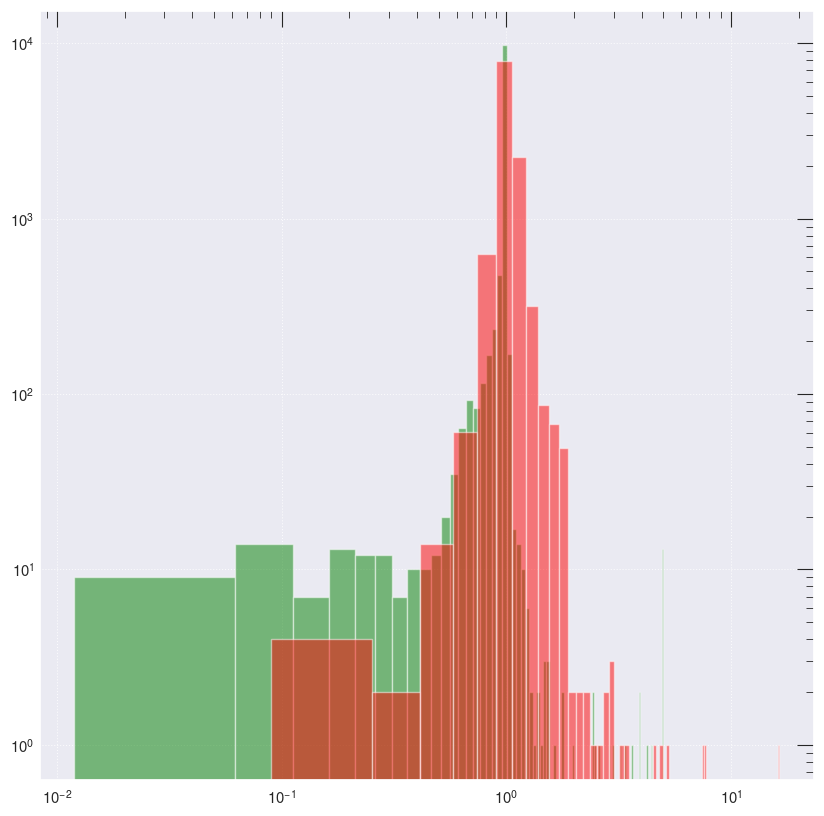

In [14]:
fig, ax = plt.subplots()
ax.hist(frac_track[track_filter].clip(max=5), bins=100, color="green", label="with track - Pandora", alpha=0.5)
ax.hist(frac_pred[track_filter], bins=100, color="red", label="with track", alpha=0.5)
ax.set_yscale("log")
ax.set_xscale("log")
fig.show()

0
1
2
3
4
5
10
15
20
25
30
35
40
60


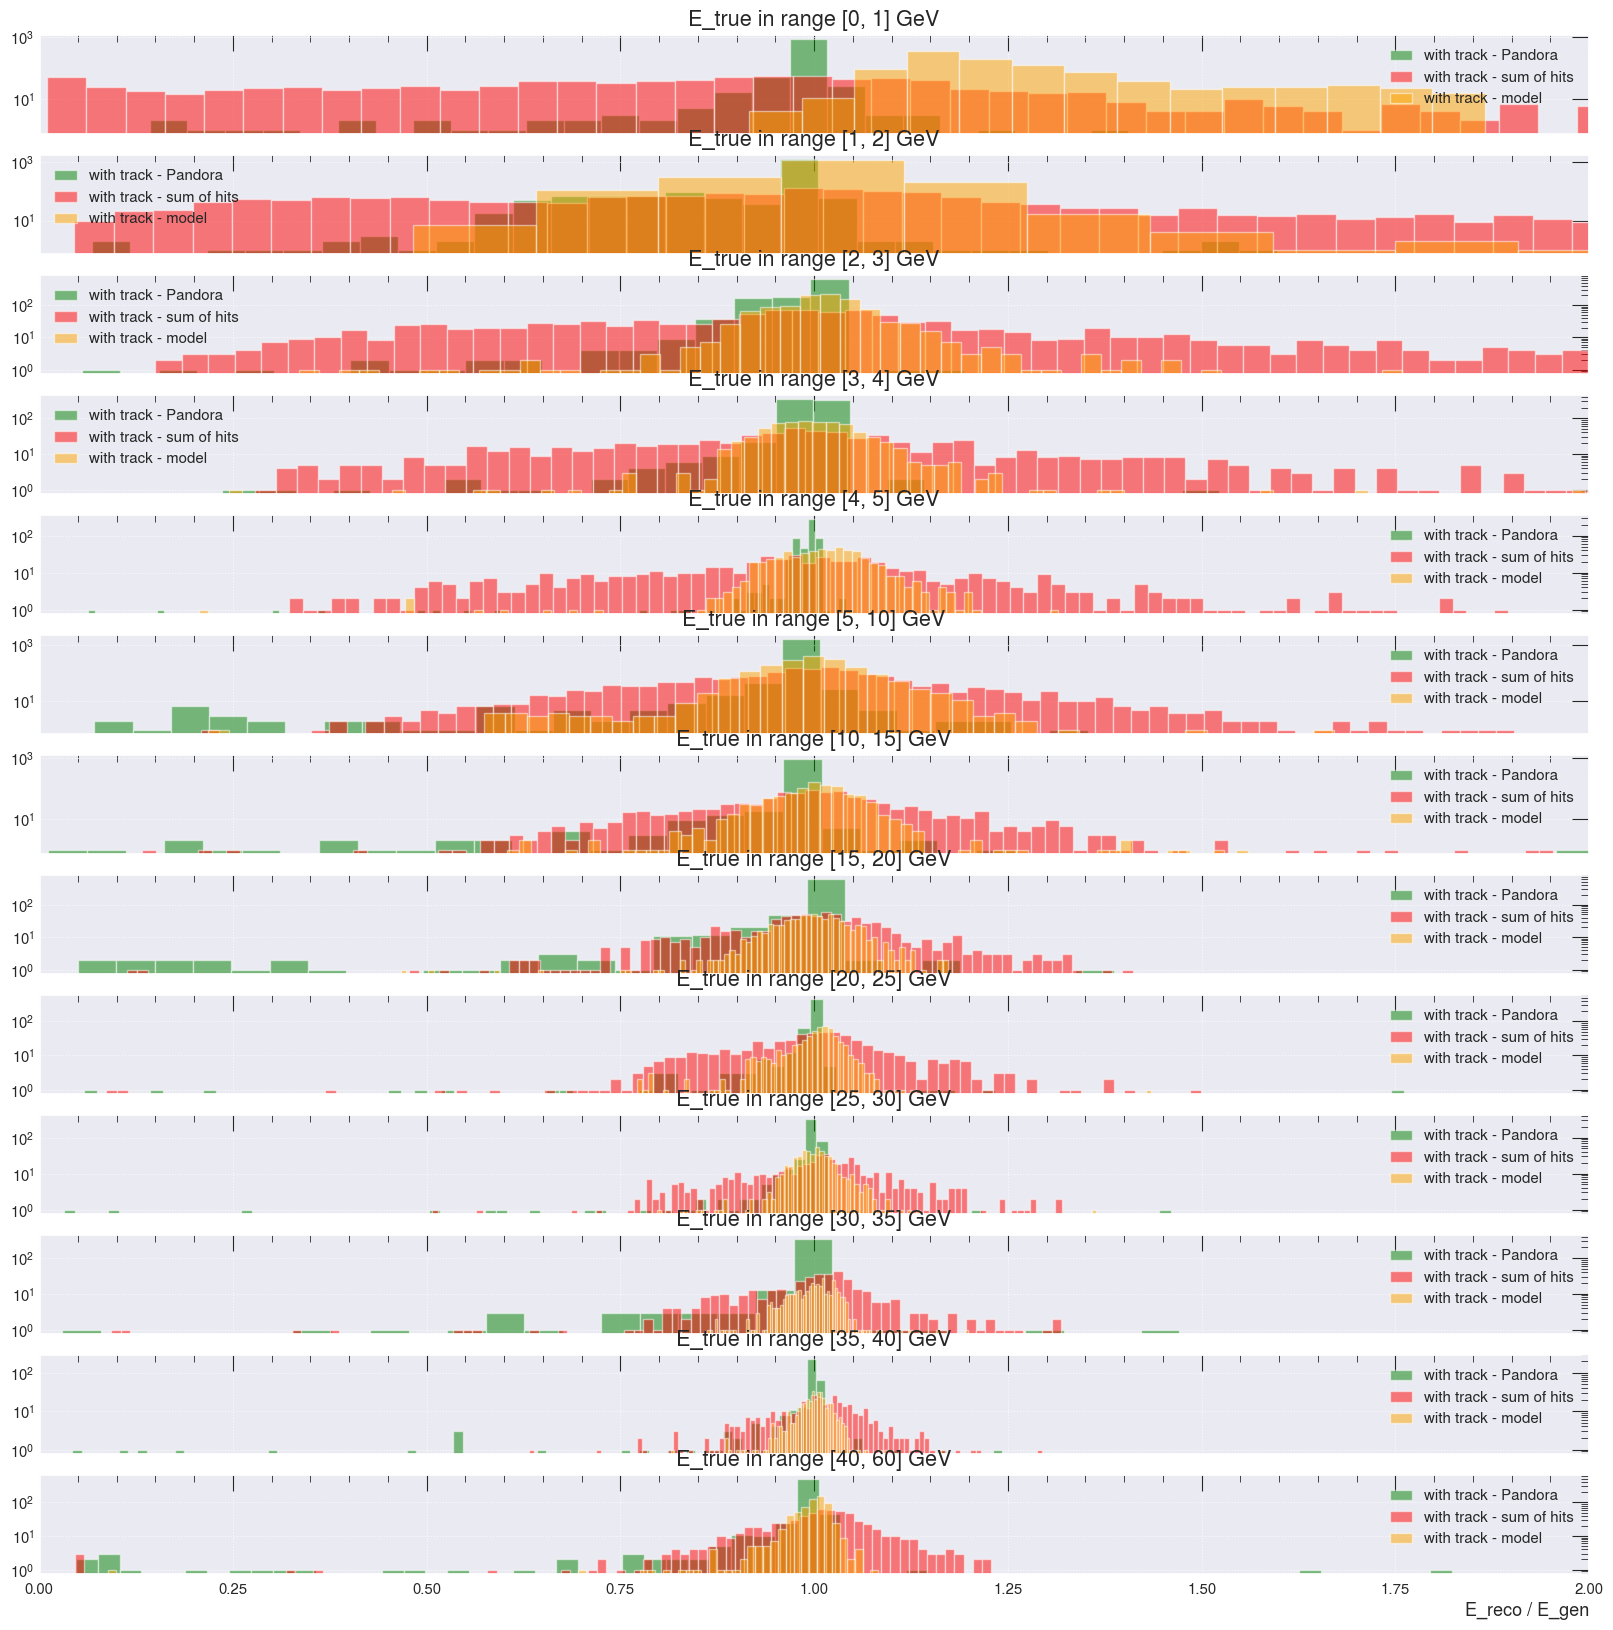

In [13]:
# Now do histograms for different energy bins: 1-2 GeV, 2-5 GeV, 5-10 GeV, 10+ GeV
# distribution of energy corr factor
e_thresholds = [0, 1, 2, 3, 4, 5, 10, 15, 20, 25, 30, 35, 40, 60]  # True E thresholds!
# set fig size

mpvs_model, s68s_model = [], []
mpvs_pandora, s68s_pandora = [], []
mpvs_sum_hits, s68s_sum_hits = [], []
mpvs_model_normalized, mpvs_pandora_normalized, mpvs_normalized_sum_hits = [], [], []

e_true = (1+yt_regression) * split_regression[1][:, 6].numpy()
#e_pred = (1+yp_regression) * split[1][:, 6].numpy()
e_pred = yp_regression
frac_pred = e_pred / e_true
frac_e_sum = split_regression[1][:, 6].clone().detach().cpu().numpy() / e_true
e_track = split_regression[1][:, 3].clone().detach().cpu().numpy()
frac_track = e_track / e_true
track_filter = ((split_regression[1][:, 3] > 0) & (split_regression[1][:, 7] == 1))
track_filter = (track_filter & ())
not_track_filter = ~track_filter



fig, ax = plt.subplots(len(e_thresholds) - 1, sharex=True, figsize=(20, 20))

binsize = 0.02 # TEMPORARILY

for i, e_threshold in enumerate(e_thresholds):
    print(e_threshold)
    if i == 0:
        continue
    filt_energy = (e_true < e_thresholds[i]) & (e_true >= e_thresholds[i-1])
    ax[i-1].hist(frac_track.clip(max=5)[track_filter & filt_energy], bins=100, color="green", label="with track - Pandora", alpha=0.5)
    ax[i-1].hist(frac_e_sum[track_filter & filt_energy], bins=100, color="red", label="with track - sum of hits", alpha=0.5)
    ax[i-1].hist(frac_pred[track_filter & filt_energy], bins=100, color="orange", label="with track - model", alpha=0.5)
    mpv, s68 = obtain_MPV_and_68(e_pred[filt_energy & track_filter], bins_per_binned_E=np.arange(0, 5*e_thresholds[i], binsize))
    mpvs_model, s68s_model = mpvs_model + [mpv], s68s_model + [s68]
    mpv, _ = obtain_MPV_and_68(frac_pred[filt_energy & track_filter], bins_per_binned_E=np.arange(0, 5, binsize))
    mpvs_model_normalized.append(mpv)
    mpv, s68 = obtain_MPV_and_68(e_track[filt_energy & track_filter], bins_per_binned_E=np.arange(0, 5*e_thresholds[i], binsize))
    mpvs_pandora, s68s_pandora = mpvs_pandora + [mpv], s68s_pandora + [s68]
    mpv, _ = obtain_MPV_and_68(frac_track[filt_energy & track_filter], bins_per_binned_E=np.arange(0, 5, binsize))
    mpvs_pandora_normalized.append(mpv)
    mpv, s68 = obtain_MPV_and_68(split_regression[1][:, 6].clone().detach().cpu().numpy()[filt_energy & track_filter], bins_per_binned_E=np.arange(0, 5*e_thresholds[i], binsize))
    mpvs_sum_hits, s68s_sum_hits = mpvs_sum_hits + [mpv], s68s_sum_hits + [s68]
    mpv, _ = obtain_MPV_and_68(frac_e_sum[filt_energy & track_filter], bins_per_binned_E=np.arange(0, 5, binsize))
    mpvs_normalized_sum_hits.append(mpv)
    # now with filt ecalE and hcalE
    #mpvs.append(1/2 * (e_thresholds[i] + e_thresholds[i-1]))
    #mpvs.append(mpv)
    #s68s.append(s68)
    #print(f"MPV: {mpv}, 68%: {s68}")
    # only hadronic
    ax[i-1].set_xlim([-1,3])
    ax[i-1].set_title(f"E_true in range [{e_thresholds[i-1]}, {e_thresholds[i]}] GeV")
    # log x axis
    ax[i-1].set_yscale("log")
    ax[i-1].legend()
    ax[i-1].set_xlim([0, 2])
ax[-1].set_xlabel("E_reco / E_gen")
#fig.savefig("/eos/user/g/gkrzmanc/2024/12_3_/frac_hist_tracks_Regression_withexactly1track.pdf")

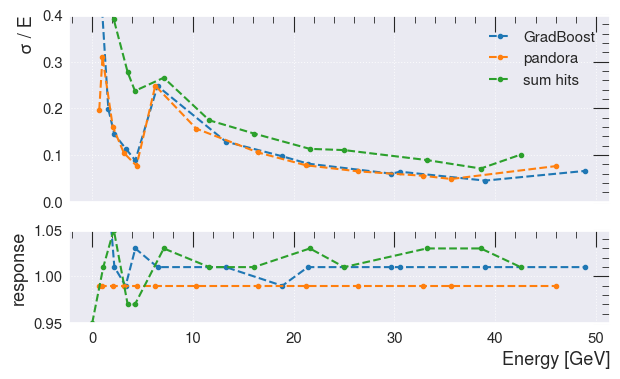

In [15]:
fig, ax = plt.subplots(2, 1, figsize=(7, 4), sharex=True, gridspec_kw={'height_ratios': [2, 1]}) # Height of 2 subplots. 
ax[0].plot(mpvs_model, np.array(s68s_model) / np.array(mpvs_model), ".--", label="GradBoost")
ax[0].plot(mpvs_pandora, np.array(s68s_pandora) / np.array(mpvs_pandora), ".--", label="pandora")
ax[0].plot(mpvs_sum_hits, np.array(s68s_sum_hits) / np.array(mpvs_sum_hits), ".--", label="sum hits")
ax[0].legend()
ax[1].set_xlabel("Energy [GeV]")
ax[0].set_ylabel("σ / E")
ax[0].set_ylim([0, 0.4])
ax[1].plot(mpvs_model, mpvs_model_normalized, ".--", label="GradBoost")
ax[1].plot(mpvs_pandora, mpvs_pandora_normalized, ".--", label="pandora")
ax[1].plot(mpvs_sum_hits, mpvs_normalized_sum_hits, ".--", label="sum hits")
ax[1].set_ylim([0.95, 1.05])
ax[1].set_ylabel("response")
fig.savefig("/eos/user/g/gkrzmanc/2024/12_3_/response_and_resolution_tracks_Regression_1track_only.pdf")

In [ ]:
frac_pred[track_filter].max()

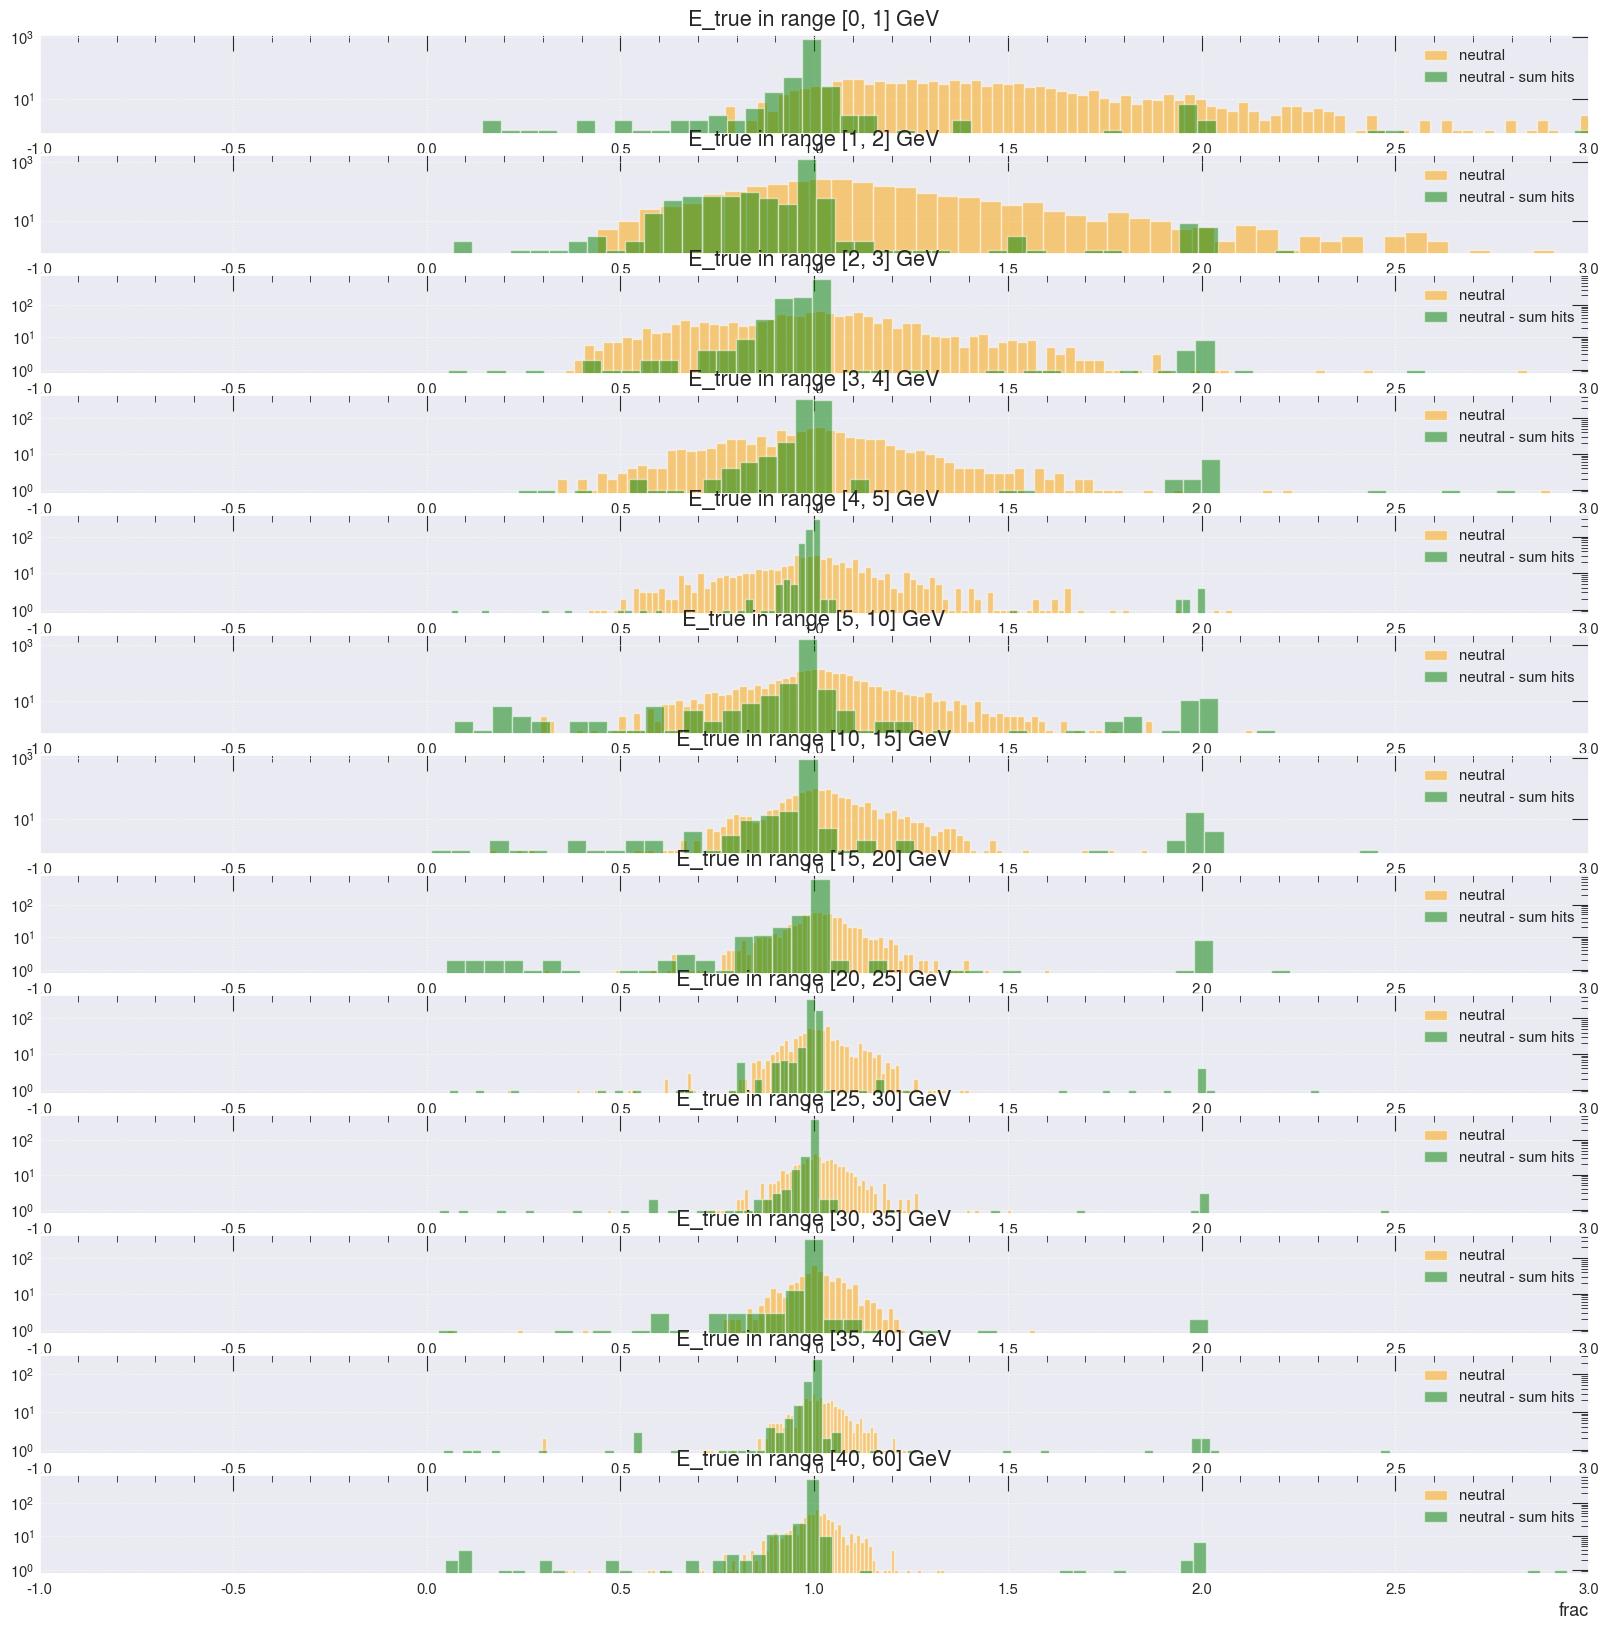

In [27]:
# Now do histograms for different energy bins: 1-2 GeV, 2-5 GeV, 5-10 GeV, 10+ GeV
# distribution of energy corr factor
e_thresholds = [0, 1, 2, 3, 4, 5, 10, 15, 20, 25, 30, 35, 40, 60]  # True E thresholds!

# set fig size
mpvs_model, s68s_model = [], []
mpvs_pandora, s68s_pandora = [], []

e_true = (1+neutral_yt) * neutral_split[1][:, 6].numpy()
e_pred = (1+neutral_yp) * neutral_split[1][:, 6].numpy()
frac_pred = e_pred / e_true
e_hits = neutral_split[1][:, 6].clone().detach().cpu().numpy()
frac_sum_hits = e_hits / e_true
not_track_filter = ((neutral_split[1][:, 3] == 0) & (neutral_split[1][:, 7] == 0))
fig, ax = plt.subplots(len(e_thresholds) - 1, figsize=(20, 20))
for i, e_threshold in enumerate(e_thresholds):
    if i == 0:
        continue
    filt_energy = (e_true < e_thresholds[i]) & (e_true >= e_thresholds[i-1])
    #print("sum", filt_energy.sum())
    ax[i-1].hist(frac_pred[not_track_filter & filt_energy], bins=100, color="orange", label="neutral", alpha=0.5)
    ax[i-1].hist(frac_track.clip(max=5)[track_filter & filt_energy], bins=100, color="green", label="neutral - sum hits", alpha=0.5)
    mpv, s68 = obtain_MPV_and_68(e_pred[filt_energy & not_track_filter], bins_per_binned_E=np.arange(0, 5*e_thresholds[i], 0.05))
    mpvs_model, s68s_model = mpvs_model + [mpv], s68s_model + [s68]
    mpv, s68 = obtain_MPV_and_68(e_track[filt_energy & not_track_filter], bins_per_binned_E=np.arange(0, 5*e_thresholds[i], 0.05))
    mpvs_pandora, s68s_pandora = mpvs_pandora + [mpv], s68s_pandora + [s68]
    # now with filt ecalE and hcalE
    #mpvs.append(1/2 * (e_thresholds[i] + e_thresholds[i-1]))
    #mpvs.append(mpv)
    #s68s.append(s68)
    #print(f"MPV: {mpv}, 68%: {s68}")
    # only hadronic
    ax[i-1].set_xlabel("frac")
    ax[i-1].set_xlim([-1,3])
    ax[i-1].set_title(f"E_true in range [{e_thresholds[i-1]}, {e_thresholds[i]}] GeV")
    # log x axis
    ax[i-1].set_yscale("log")
    ax[i-1].legend()
fig.savefig("/eos/home-g/gkrzmanc/2024/12_3_/frac_hist_neutral.pdf")

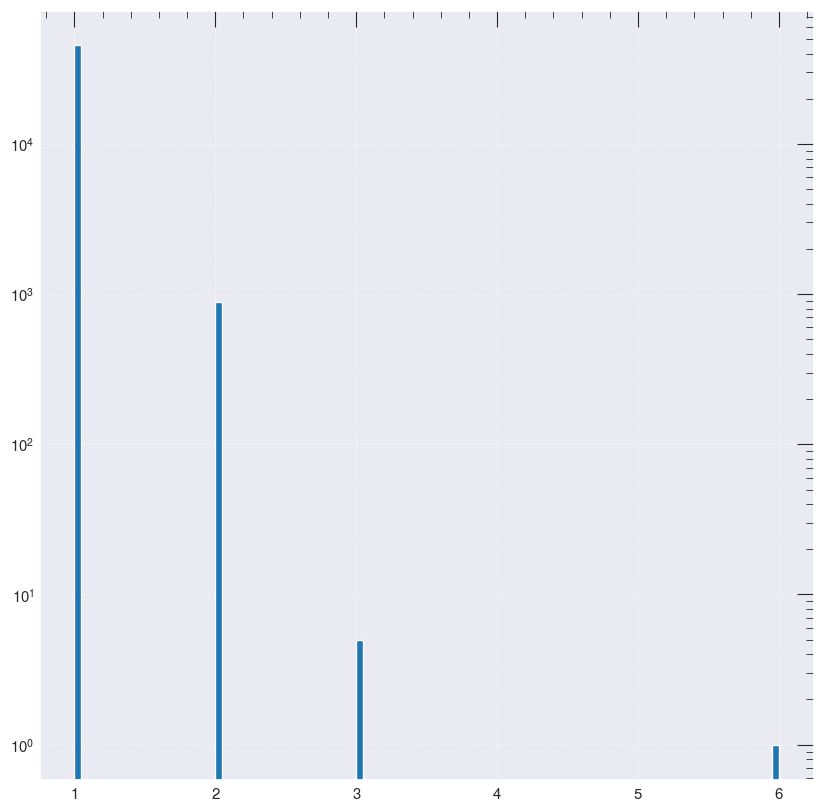

In [30]:
fig, ax = plt.subplots()
ax.hist(split[0][:,7], bins=100)
ax.set_yscale("log")
fig.show()